# 💻 UnpackAI DL201 Bootcamp - Week 1 - Skills: Computer Vision

## 📕 Learning Objectives

* Loading data
* Unzipping data
* Retrieving label information
* AI model training and results analysis on Computer Vision

# Part 0 : Code preparation

In [1]:
import pandas as pd
import numpy as np
import cv2 
import torch as t
from matplotlib import pyplot as plt
from pathlib import Path
import os
from shutil import unpack_archive

# import data and images if necessary, and choose the right path
PLATFORM = 'Kaggle'  # or 'UNIX' or 'Kaggle'

if PLATFORM == 'Kaggle':
    !pip install openpyxl
    !git clone https://github.com/unpackAI/DL201.git
    IMAGE_DIR = Path('/kaggle/working/DL201/img')
    DATA_DIR = Path('/kaggle/working/DL201/data')
    
elif PLATFORM == 'UNIX':
    # we assume that you already cloned unpackAI/DL201 git repository
    # and this notebook is part of DL201/week1 directory
    DATA_DIR = Path.home()/'Datasets/unpackAI/DL201/data'
    IMAGE_DIR = Path.home()/'Projects/unpackAI/DL201/img'
    
elif PLATFORM == 'WINDOWS':
    # we assume that you already cloned unpackAI/DL201 git repository
    # and this notebook is part of DL201/week1 directory
    DATA_DIR = Path('../data') #uncomment for kaggle
    IMAGE_DIR = Path('../img') #Uncomment for Kaggle
    
# finally, check if we found the right pathes
if os.path.isdir(DATA_DIR):
    print(f'DATA_DIR is a directory, its path is {DATA_DIR}')
else:
    print("ERROR : DATA_DIR is not a directory")

if os.path.isdir(IMAGE_DIR):
    print(f'IMAGE_DIR is a directory, its path is {IMAGE_DIR}')
else:
    print("ERROR : IMAGE_DIR is not a directory")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 1.4 MB/s eta 0:00:00
Cloning into 'DL201'...
remote: Enumerating objects: 869, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 869 (delta 89), reused 78 (delta 46), pack-reused 725
Receiving objects: 100% (869/869), 58.63 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (511/511), done.
DATA_DIR is a directory, its path is /kaggle/working/DL201/data
IMAGE_DIR is a directory, its path is /kaggle/working/DL201/img


# Part 1: Loading the data
<hr style="border:4px solid gray"> </hr>

As always, the question becomes, how do we access our data.

## 1.1 How Large is the dataset?

Before downloading the data, it is a good idea to know how large the dataset is because this will affect how you move forward. If it is very large, you may need to consider if you can download it or not, how much time this would take, how it will be stored in your computer, etc.

You may need to select a sample out of the dataset to work with rather than work with the whole set. This will speed up exploring the data because you won't constantly be waiting for the computer to process the data.

This information is usually found online, in the Readme following the data or displayed by your computer when you start downloading.

## 1.2 Working with compressed files?

***Zip*** files are incredibly common in many areas.

For datasets, they serve two primary purposes:

1. This format bundles together many files into one and makes it easier and faster to send it over the internet. Network protocols are similar to the mail. It's much less complicated to send a shipping container rather than do paperwork and handling of thousands of individual boxes.

2. Compression. The other problem is bandwidth. Zip files, along with other formats, can make files smaller which is beneficial because they take up less space on the hard drive. More importantly, this means that we can download the dataset faster. 

### Step 1: Find the exact file path

In [2]:
# Setting the file path using pathlib
emotionsImagesZipPath = DATA_DIR/'CV'/'Emotions_Images_Sample.zip'
os.path.isfile(emotionsImagesZipPath)

True

### Step 2: Unzip the files

In this code, we are using a library called ***shutil***
Shutil is short for shell utility.

This allows python to make commands in the shell.

In this case, we are telling it to unzip a file X and put it in Y directory.
X is a file path while Y is a directory path.

In [3]:
Output_Directory = os.path.join(DATA_DIR,'OutputDirectory')
if not os.path.isdir(Output_Directory): #this allows us to run the cell several times
    os.mkdir(Output_Directory)
    unpack_archive(emotionsImagesZipPath, Output_Directory)

### Step 3: Check the file path

Now that we extracted the data, we now need to make sure that we know where our data is, and check up on it before proceeding to the next level.

Check the output of the next command and see what it is doing.

In [4]:
os.listdir(Output_Directory)

['Emotions_Images_Sample']

In [5]:
EMOTIONS_IMAGES_DIR = os.path.join(Output_Directory,'Emotions_Images_Sample')
labels = os.listdir(EMOTIONS_IMAGES_DIR)
print(labels)

['Disgust', 'Surprise', 'Happy', 'Angry', 'Neutral', 'Sad', 'Fear']


Here, we see a list of labels as directory names. Let's remind the different ways to connect the pictures and their metadata such as labels.

## 1.3 Ways of storing the data and metadata

Many computer vision data sets are organized in three ways.

<dt>File trees</dt>
<df>The picture files are grouped by meaningfull directories. We may find their label and other information about them with the directory they belong to. Finding them is done by exploring what is called a ***file tree***</df>

<dt>Metadata</dt>
<df>The picture files are not well separated in the file tree, or might even be stored on different repositories on the web. To retrieve them and the corresponding labels, we have a Metadata file (can be a JSON or CSV file) containing the file list, file paths and other information like the labels</df>

<dt>File names</dt>
<df>As we saw in the PETS dataset, where cats were lowercases and dogs were uppercases file names, some pictures of some datasets contain their label inside the filename itself</df>

## 1.4 Class analysis from file tree
Here, the labels are conveniently stored as directory names, so they are easy to extract.

In [6]:
print(f'total number of labels: {len(labels)}')

total number of labels: 7


In [7]:
instancesPerClassDict = {}

filepathDictionary = {}

for label in os.listdir(EMOTIONS_IMAGES_DIR):
    
    # This gives us a label for each bit of code
    imagesDirectory = os.path.join(EMOTIONS_IMAGES_DIR,label)
    
    # This code gives a list of all the images in the directory
    
    images = os.listdir(imagesDirectory)
    for fileName in images:
        
        imagePath = os.path.join(imagesDirectory,fileName) # makes a longer path
        # use imagePath to do something
            
    instancesPerClassDict[label] = len(images)
    
for key, value in instancesPerClassDict.items():
    print(f'Class: ({key}) contains {value} instances')


Class: (Disgust) contains 51 instances
Class: (Surprise) contains 101 instances
Class: (Happy) contains 51 instances
Class: (Angry) contains 51 instances
Class: (Neutral) contains 51 instances
Class: (Sad) contains 51 instances
Class: (Fear) contains 51 instances


Now, we have our data in a format that it can be put into a fastAI model to give us more information.

## 1.5 Class analysis from Metadata File

In some cases, the files may be located on a cloud server, or put together into one large directory. This means that the information is not organized with a file tree, but rather in metadata.

This metadata can come as a CSV or a JSON File.

Here, we work with the google landmarks image dataset, it contains lots of information on different photos that users have uploaded along with different kinds of metadata.

However, the  dataset is quite large, so it makes more sense to have an individual metadata files. It can allows us to donwload only the pictures we want.

These metadata files contain both the labels and the file paths that we need.

***Identifying the x and the y***
The features (x) in this case are the images ; labels (y) in this case are the landmark IDs.

In [8]:
googleLandmarksPath = os.path.join(DATA_DIR,'CV','landmarks')
os.path.isdir(googleLandmarksPath)

True

In [9]:
# This snippet can be useful for handling many csv files
# This code does not work on Windows environment

for dirname, _, filenames in os.walk(googleLandmarksPath):
    for filename in filenames:  # loops through all the files in the directories
        print(filename) # Gives a file name, without the complete file path
        filepath = os.path.join(dirname,filename) # Completes the file path
        filename = filename.split('.')[0] # Removes the file extension for naming
        if os.path.isfile(filepath):
            ExecString = f"{filename} = pd.read_csv('{filepath}')"
            print(ExecString)
            exec(ExecString)
        else:
            print(f'there is a problem with {filepath}')

landmarksample.csv
landmarksample = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/landmarksample.csv')
boxes_split1.csv
boxes_split1 = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/boxes_split1.csv')
train.csv
train = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/train.csv')
retrieval_solution.csv
retrieval_solution = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/retrieval_solution.csv')
index.csv
index = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/index.csv')
recognition_solution.csv
recognition_solution = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/recognition_solution.csv')
boxes_split2.csv
boxes_split2 = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/boxes_split2.csv')
test.csv
test = pd.read_csv('/kaggle/working/DL201/data/CV/landmarks/test.csv')


Now that we loaded all the metadata files. We will look at their name to know what they represent, and check their shape to know rapidly the number of features and sample they describe. If the name of the file is not clear enough, we can sometimes get some information by observing the relationships between the shapes of two files.

In [10]:
# Train
print(train.shape)
train.head()

(2000, 4)


,Unnamed: 0,id,url,landmark_id
0,1221181,638a7921e893de63,http://lh6.ggpht.com/-okvU3kjsKWQ/TjnHZCjgLdI/...,3918
1,393869,ec108f2c67d28082,https://lh4.googleusercontent.com/-ghGLWnz_5Nw...,4786
2,833769,8b8d9329e3fccd0a,https://lh4.googleusercontent.com/-49VHsrW3voo...,6090
3,400348,cf6b02c51de2f6a1,http://lh6.ggpht.com/-6Afsd7_E_ck/RsSKkV5EnnI/...,6051
4,749128,c798f1620d54d8c1,None,None


In [11]:
train.drop(['Unnamed: 0'],axis=1,inplace=True)
print(train.shape)
train.head()

(2000, 3)


,id,url,landmark_id
0,638a7921e893de63,http://lh6.ggpht.com/-okvU3kjsKWQ/TjnHZCjgLdI/...,3918
1,ec108f2c67d28082,https://lh4.googleusercontent.com/-ghGLWnz_5Nw...,4786
2,8b8d9329e3fccd0a,https://lh4.googleusercontent.com/-49VHsrW3voo...,6090
3,cf6b02c51de2f6a1,http://lh6.ggpht.com/-6Afsd7_E_ck/RsSKkV5EnnI/...,6051
4,c798f1620d54d8c1,None,None


In this dataset, the label is the landmark ID

The file location is a little more tricky because it is stored on google's servers, and needs to be downloaded. 

In [12]:
landmarkLabels = train['landmark_id']
landmarkURLs = train['url']

Although these are different, the principles remain the same as before : we need to know what the image is, and where the image is stored. The label and the file path/url will hold this information.

You can check another example here : https://www.kaggle.com/piyushrg/computer-vision-av-fastai/notebook

## Part 2 : Loading the data into the dataloader
<hr style="border:4px solid gray"> </hr>


In order to leverage a fastAI model, the two key pieces of information that we will need to fit the data into the model are the ***labels***, and how the images are stored. 

Once we can do that, we can go ahead and train a ***preliminary model*** to get quantified information on how to build the final model.

In [13]:
# Imports, this cell must be run twice because there are dependencies problems with the preloaded libraries of Kaggle
!pip install -Uqq fastbook[full]

from fastbook import *
from fastai.vision.widgets import *
setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

### Loading the Data into FastAI Dataloader

Once we have the paths of each image, we can use a dataloader to preprocess and transform the data automatically for us using FastAI

In [14]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [15]:
emotions = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    item_tfms=Resize(225,225)
    )

In [16]:
emotions = emotions.new(
    item_tfms=RandomResizedCrop(28, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [17]:
dls = emotions.dataloaders(EMOTIONS_IMAGES_DIR)

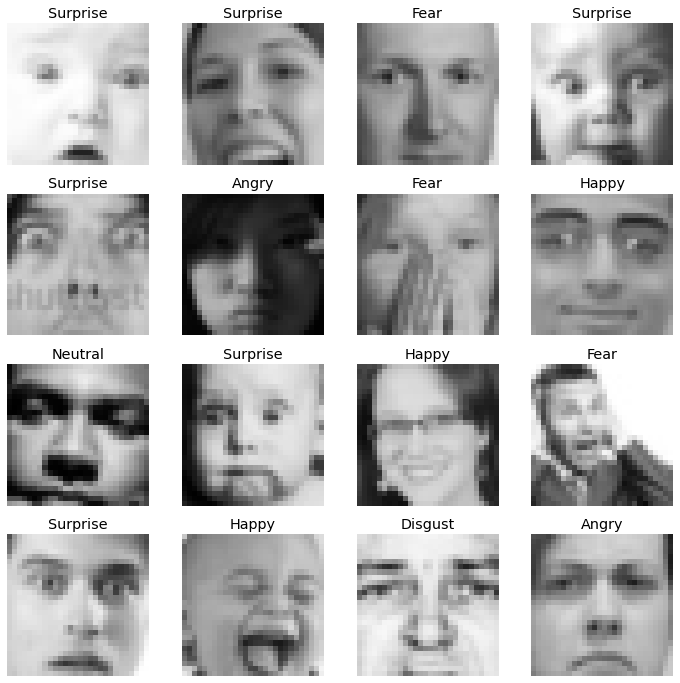

In [18]:
dls.valid.show_batch(max_n=16, nrows=4)

# Part 2 : Training the Model

In [19]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,3.372157,3.261595,0.876543,00:02


epoch,train_loss,valid_loss,error_rate,time
0,3.154098,2.960824,0.901235,00:06
1,3.056150,2.598497,0.888889,00:06
2,3.010441,2.438319,0.827160,00:06
3,2.917172,2.373462,0.827160,00:06
4,2.923556,2.395353,0.802469,00:06


# Part 3: Interpreting the Results

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

### What is the Accuracy of the Model?

In [22]:
interp.print_classification_report()

              precision    recall  f1-score   support

       Angry       0.18      0.25      0.21        12
     Disgust       0.08      0.14      0.11         7
        Fear       0.40      0.12      0.19        16
       Happy       0.14      0.12      0.13         8
     Neutral       0.10      0.11      0.11         9
         Sad       0.08      0.33      0.12         3
    Surprise       0.41      0.27      0.33        26

    accuracy                           0.20        81
   macro avg       0.20      0.19      0.17        81
weighted avg       0.27      0.20      0.21        81



### What Does the Confusion Matrix Look Like?

interp.confusion

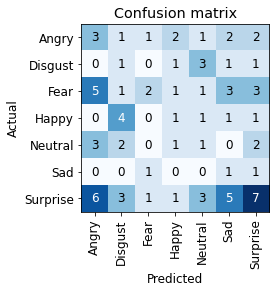

In [23]:
interp.plot_confusion_matrix()

### Do you see any clear patterns in the confusion matrix?

* Can you think of reasons why it got confused?

### What are the Most Confused Images?

* Should any of these Images be removed from the Dataset? 
* Are they Clustered in One or a Few Classes?

### Are they Distributed across many Classes?

### Can you find any poor quality images?

### Can Filters be Applied to Improve the Quality of the Images?

### Are any Features Blocked or Occluded in these images?

### Can any Features be Highlighted to Improve the Model's Performance?

### Where Does this First Run Strengthen your Hypothesis?

### Have Any Other Weaknesses in the Model been Revealed? 

### Are There Any Major Class Inbalances that Affect Model Performance?

* Can These be improved by Image Augmentation? 

### Can you collect more data in areas where your model is weak?

* Can you Easily Find More Data by Reverse Image Searching the Most Confused Images?

### How Could Image Preprocessing Make Features More Apparent to the Model?